First we will start by bringing some code we need to start with this like our custom class, custom dataset and functions for training and testing

In [97]:
import torch
from torch import nn
import torchvision
import pathlib
import matplotlib.pyplot as plt

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [98]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [99]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [100]:
train_dir= image_path / "train"
test_dir=  image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [101]:
from torchvision import transforms
from typing import Tuple, Dict, List
def find_classes(directory:str)-> Tuple[List[str], Dict[str, int]]:
    classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    classes_to_idx= {cls_name:i for i, cls_name in enumerate(classes)}
    return classes, classes_to_idx

In [102]:
#now we are going to create the custom Dataset class
from torch.utils.data import Dataset
from pathlib import Path

class ImageFolderCustom(Dataset): # we need to subclass Dataset
    def __init__(self, target_dir:str, transform:None) ->None:
        self.paths= list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform= transform
        self.classes, self.classes_to_idx = self.find_classes(target_dir)
    
    def find_classes(self,directory:str)-> Tuple[List[str], Dict[str, int]]:
        self.classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not self.classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}")
        self.classes_to_idx= {cls_name:i for i, cls_name in enumerate(self.classes)}
        return self.classes, self.classes_to_idx
    
    def load_image(self, index:int):
        image_path= self.paths[index]
        return Image.open(image_path)
    
    # here we will overide the method that returns length
    def __len__(self)->int:
        return len(self.paths)
    
    # overide(necessary) getitem method which returns one sample of data (image and label)
    def __getitem__(self, index):
        img= self.load_image(index)
        class_name= self.paths[index].parent.name
        class_idx= self.classes_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [103]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [104]:
def train_run(
    model:nn.Module,
    train_data:torch.utils.data.DataLoader,
    lossFn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device:torch.device    
):
    loss_total=0
    model.to(device)
    model.train()
    true_predictions=0
    total_image_count= 0
    for i, (a_batch_images, labels) in enumerate(train_data):
            a_batch_images=a_batch_images.to(device)
            labels= labels.to(device)
            y_logits= model(a_batch_images)
            y_preds= torch.argmax(y_logits, dim=1)
            loss= lossFn(y_logits, labels)
            loss_total += loss.item()
            true_predictions += (labels == y_preds).sum().item()
            total_image_count += len(labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
    loss= loss_total / len(train_data)
    accuracy = true_predictions /  total_image_count
    return {
        'loss': loss,
        'accuracy': accuracy
    }

def test_run(
    model: nn.Module,
    test_data: torch.utils.data.DataLoader,
    lossFn: nn.Module,
    device: torch.device
):
    loss_total = 0
    true_predictions = 0
    total_image_count = 0

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (a_batch_images, labels) in enumerate(test_data):
            a_batch_images = a_batch_images.to(device)
            labels = labels.to(device)

            y_logits = model(a_batch_images)
            y_preds = torch.argmax(y_logits, dim=1)

            loss = lossFn(y_logits, labels)
            loss_total += loss.item()

            true_predictions += (labels == y_preds).sum().item()
            total_image_count += len(labels)

    loss = loss_total / len(test_data)
    accuracy = true_predictions / total_image_count

    return {
        "loss": loss,
        "accuracy": accuracy
    }
    

from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
    epochs: int = 5
):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):

        train_metrics = train_run(
            model=model,
            train_data=train_dataloader,
            lossFn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_metrics = test_run(
            model=model,
            test_data=test_dataloader,
            lossFn=loss_fn,
            device=device
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_metrics['loss']:.4f} | "
            f"train_acc: {train_metrics['accuracy']:.4f} | "
            f"test_loss: {test_metrics['loss']:.4f} | "
            f"test_acc: {test_metrics['accuracy']:.4f}"
        )

        results["train_loss"].append(train_metrics["loss"])
        results["train_acc"].append(train_metrics["accuracy"])
        results["test_loss"].append(test_metrics["loss"])
        results["test_acc"].append(test_metrics["accuracy"])

    return results

In [105]:
def find_classes(directory:str)-> Tuple[List[str], Dict[str, int]]:
    classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    classes_to_idx= {cls_name:i for i, cls_name in enumerate(classes)}
    return classes, classes_to_idx

In [106]:
from torchvision import transforms
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_data_simple= ImageFolderCustom(train_dir, simple_transform)
test_data_simple= ImageFolderCustom(test_dir, simple_transform)
train_dataloader_simple= DataLoader(
    dataset= train_data_simple,
    batch_size=1, 
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_dataloader_simple= DataLoader(
    dataset= test_data_simple,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=False
)



In [107]:
from timeit import default_timer as timer
from PIL import Image
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 30
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data_simple.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device= device,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1103 | train_acc: 0.2978 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0996 | train_acc: 0.3156 | test_loss: 1.0990 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0992 | train_acc: 0.3111 | test_loss: 1.0995 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0989 | train_acc: 0.3244 | test_loss: 1.0993 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0991 | train_acc: 0.3378 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.1112 | train_acc: 0.4000 | test_loss: 1.0679 | test_acc: 0.4800
Epoch: 7 | train_loss: 1.0033 | train_acc: 0.5556 | test_loss: 1.0043 | test_acc: 0.4800
Epoch: 8 | train_loss: 0.9532 | train_acc: 0.5689 | test_loss: 0.9771 | test_acc: 0.4667
Epoch: 9 | train_loss: 0.8808 | train_acc: 0.6311 | test_loss: 1.0090 | test_acc: 0.4667
Epoch: 10 | train_loss: 0.8078 | train_acc: 0.6222 | test_loss: 1.0576 | test_acc: 0.4533
Epoch: 11 | train_loss: 0.7481 | train_acc: 0.6711 | test_loss: 1.0159 | test_acc: 0.4933
Epoch: 12 | train_l

In [108]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


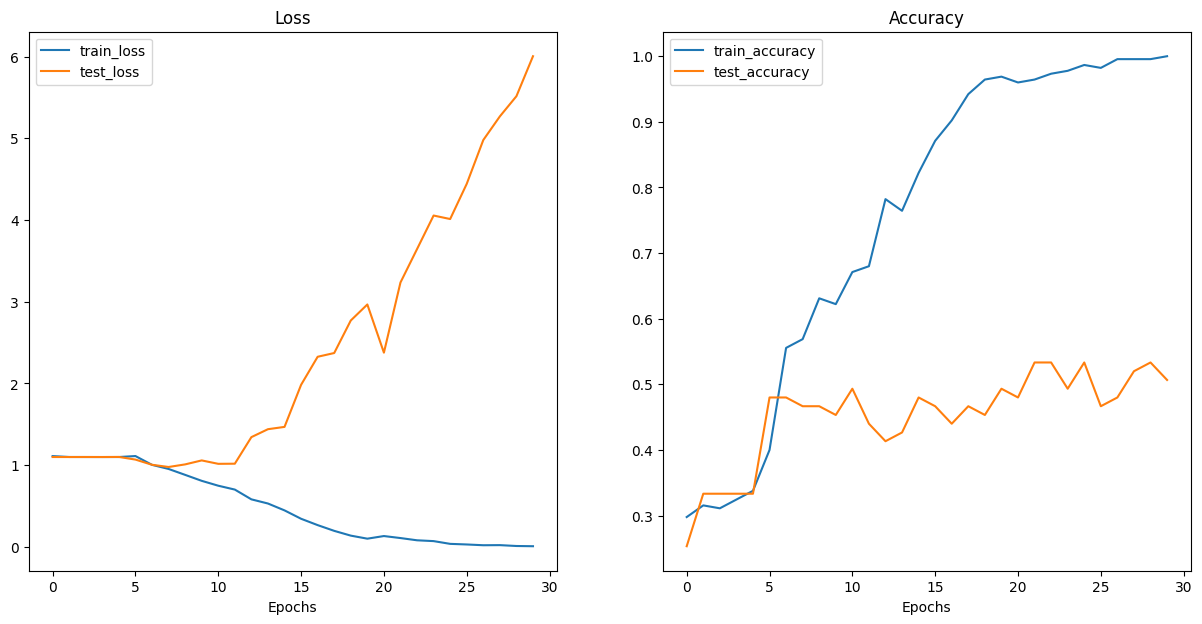

In [109]:
print(model_0_results.keys())
plot_loss_curves(model_0_results)

# We have completed importing all neccessary code from part one

This time, let's load in the data and use data augmentation to see if it improves our results in anyway

In [110]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [111]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=10, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [112]:
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=1, 
                                        num_workers=NUM_WORKERS,
                                        shuffle=True,)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=1,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)


In [113]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [114]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        device=device,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1097 | train_acc: 0.2800 | test_loss: 1.1007 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.0996 | train_acc: 0.3111 | test_loss: 1.1011 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0994 | train_acc: 0.3156 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3333 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0991 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0991 | train_acc: 0.3822 | test_loss: 1.0827 | test_acc: 0.3733
Epoch: 8 | train_loss: 1.0688 | train_acc: 0.4489 | test_loss: 1.0284 | test_acc: 0.5067
Epoch: 9 | train_loss: 1.0117 | train_acc: 0.5467 | test_loss: 1.0110 | test_acc: 0.5067
Epoch: 10 | train_loss: 0.9933 | train_acc: 0.5333 | test_loss: 0.9792 | test_acc: 0.4800
Epoch: 11 | train_loss: 0.9794 | train_acc: 0.5022 | test_loss: 0.9636 | test_acc: 0.5333
Epoch: 12 | train_l

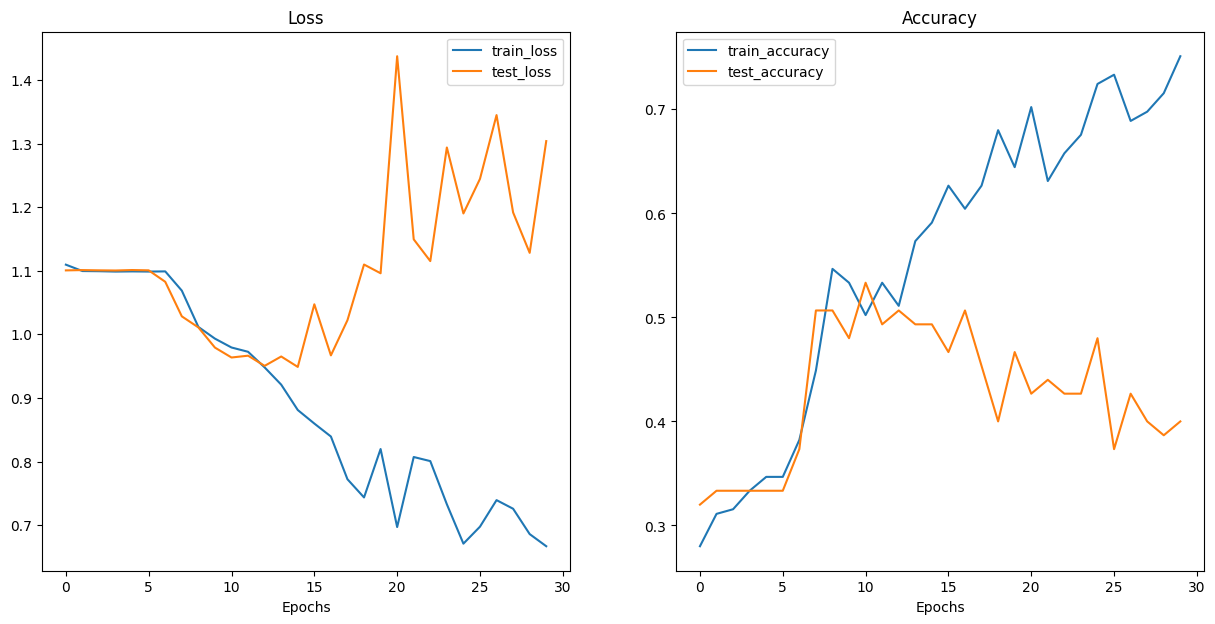

In [115]:
plot_loss_curves(model_1_results)

In [116]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.109686,0.280000,1.100666,0.320000
1,1.099634,0.311111,1.101143,0.333333
2,1.099363,0.315556,1.100744,0.333333
3,1.098794,0.333333,1.100489,0.333333
4,1.099073,0.346667,1.101219,0.333333
5,1.098813,0.346667,1.100739,0.333333
6,1.099091,0.382222,1.082715,0.373333
7,1.068829,0.448889,1.028362,0.506667
8,1.011687,0.546667,1.010955,0.506667
9,0.993295,0.533333,0.979215,0.480000


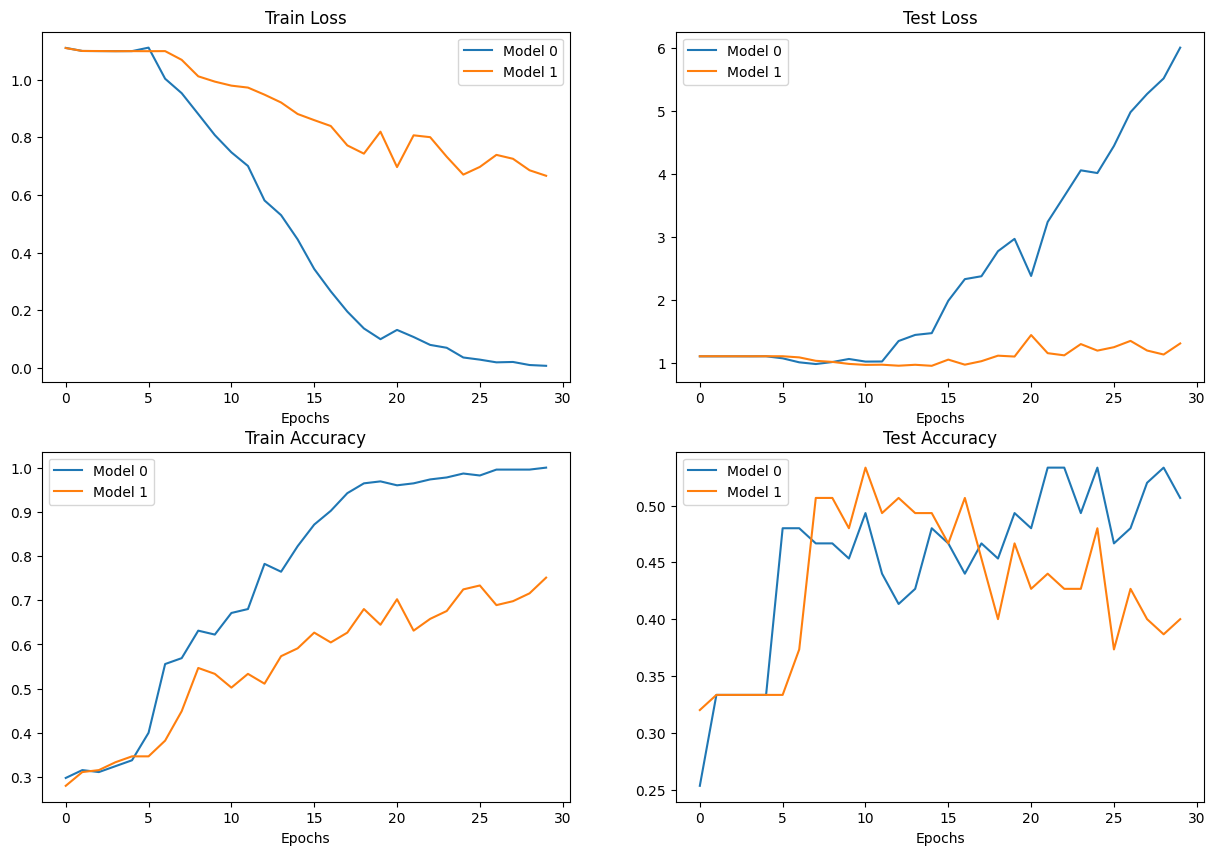

In [117]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
cp ./drive/MyDrive/'Colab Notebooks'/images/sushi.jpg ./data


In [120]:
import os
os.listdir("/content/drive/MyDrive/Colab Notebooks/images")

['pizera.jpg', 'skk.jpg', 'sushi.jpg']

In [121]:
from PIL import Image
from pathlib import Path
from torchvision import transforms

# Path to your image
piza_image_folder = Path('data')
piza_path = piza_image_folder / 'sushi.jpg'

# Read as PIL image
custom_image_pil = Image.open(piza_path)

# Define transform: resize + convert to tensor
transform_image_for_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Apply transform
custom_image_tensor = transform_image_for_test(custom_image_pil)

# Add batch dimension
custom_image_tensor = custom_image_tensor.unsqueeze(0).to(device)


print(custom_image_tensor.shape)

torch.Size([1, 3, 64, 64])


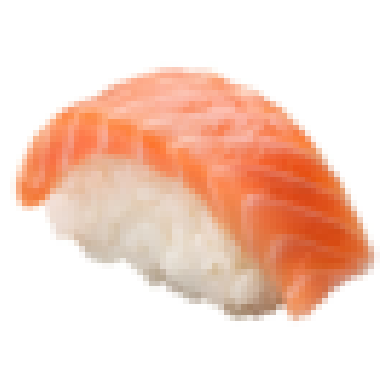

In [122]:
import matplotlib.pyplot as plt
import torchvision

# custom_image_tensor has shape [1, 3, 64, 64], remove batch dim
image_to_show = custom_image_tensor.squeeze(0).to('cpu')  # shape: [3, 64, 64]

# Convert tensor to HWC format for matplotlib (channels last)
image_to_show = image_to_show.permute(1, 2, 0)

# Display the image
plt.imshow(image_to_show)
plt.axis('off')  # optional, hides axes
plt.show()

In [123]:
classes= find_classes(train_dir)[0]
logit=model_1(custom_image_tensor)
pred= torch.argmax(logit, dim=1)
print(classes[pred])
print(logit)



pizza
tensor([[ 0.6793, -3.2401, -0.5199]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Eventhough the final predictions of the models are poor we have demonstrated how to predict ona custom image by chaning it to the proper tensor shaper and applying transforms which was our main objective so this is a conclusion text of this chapter. The reason for the poor model performance is our dataset it verysmall with only 225 images